# Extraction et Enrichissement des données + Envoie d'alertes par mail

In [ ]:
import feedparser
import requests
import re
import pandas as pd
import smtplib
from email.mime.text import MIMEText
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Extraction des Flux RSS
def extract_rss_feed(url):
    print(f"Extraction des flux RSS depuis : {url}")
    try:
        rss_feed = feedparser.parse(url)
        entries = []
        for entry in rss_feed.entries:
            entries.append({
                "title": entry.title,
                "description": entry.description,
                "link": entry.link,
                "published": entry.published
            })
        print(f"{len(entries)} entrées extraites.")
        return entries
    except Exception as e:
        print(f"Erreur lors de l'extraction RSS : {e}")
        return []

# Étape 2 : Extraction des CVE
def extract_cves_from_json(url):
    print(f"Extraction des CVE depuis le JSON : {url}")
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Erreur lors de l'accès au JSON : {response.status_code}")
            return []

        data = response.json()

        # Extraire les CVE depuis la clé "cves"
        cves_from_key = [cve["name"] for cve in data.get("cves", [])]

        # Extraire les CVE avec une regex
        cve_pattern = r"CVE-\d{4}-\d{4,7}"
        cves_from_regex = list(set(re.findall(cve_pattern, str(data))))

        # Fusionner les résultats uniques
        cves = list(set(cves_from_key + cves_from_regex))
        print(f"{len(cves)} CVE trouvées.")
        return cves
    except Exception as e:
        print(f"Erreur lors de l'extraction des CVE : {e}")
        return []

# Étape 3 : Enrichissement des CVE
def enrich_cve_with_mitre(cve_id):
    print(f"Enrichissement de la CVE via MITRE : {cve_id}")
    url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Erreur pour {cve_id}: {response.json().get('message', 'Erreur inconnue')}")
            return {
                "cve_id": cve_id,
                "cvss_score": None,
                "cwe": "Non disponible",
                "cwe_desc": "Non disponible",
                "affected_products": []
            }

        data = response.json()

        # Extraire le score CVSS
        cvss_score = None
        metrics = data["containers"]["cna"].get("metrics", [])
        if metrics:
            cvss_score = metrics[0].get("cvssV3_1", {}).get("baseScore", None)

        # Extraire le type CWE
        cwe = "Non disponible"
        cwe_desc = "Non disponible"
        problemtype = data["containers"]["cna"].get("problemTypes", [])
        if problemtype and "descriptions" in problemtype[0]:
            cwe = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cwe_desc = problemtype[0]["descriptions"][0].get("description", "Non disponible")

        # Extraire les produits affectés
        affected_products = []
        for product in data["containers"]["cna"].get("affected", []):
            vendor = product["vendor"]
            product_name = product["product"]
            versions = [v["version"] for v in product["versions"] if v["status"] == "affected"]
            affected_products.append({
                "vendor": vendor,
                "product": product_name,
                "versions": versions
            })

        return {
            "cve_id": cve_id,
            "cvss_score": cvss_score,
            "cwe": cwe,
            "cwe_desc": cwe_desc,
            "affected_products": affected_products
        }
    except Exception as e:
        print(f"Erreur lors de l'enrichissement pour {cve_id} : {e}")
        return {
            "cve_id": cve_id,
            "cvss_score": None,
            "cwe": "Non disponible",
            "cwe_desc": "Non disponible",
            "affected_products": []
        }

def enrich_cve_with_epss(cve_id):
    print(f"Enrichissement de la CVE via EPSS : {cve_id}")
    url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Erreur pour {cve_id}: {response.status_code}")
            return {"cve_id": cve_id, "epss_score": None}

        data = response.json()

        # Extraire le score EPSS
        epss_data = data.get("data", [])
        epss_score = epss_data[0]["epss"] if epss_data else None

        return {"cve_id": cve_id, "epss_score": epss_score}
    except Exception as e:
        print(f"Erreur lors de l'enrichissement pour {cve_id} : {e}")
        return {"cve_id": cve_id, "epss_score": None}

def enrich_cve(cve_id):
    mitre_data = enrich_cve_with_mitre(cve_id)
    epss_data = enrich_cve_with_epss(cve_id)
    mitre_data.update(epss_data)  # Fusion des résultats
    return mitre_data

def limit_cve_enrichment(cve_list, limit=20):
    print(f"Enrichissement des CVE (limité à {limit})...")
    enriched_cves = []
    cve_list = list(cve_list)  # Convertir l'ensemble en liste pour permettre l'indexation
    for cve_id in cve_list[:limit]:  # Appliquer la limite
        enriched_cves.append(enrich_cve(cve_id))
    return enriched_cves

# Étape 4 : Consolidation des données
def consolidate_data(entries, enriched_cves):
    print("Consolidation des données dans un DataFrame...")
    data = []
    cve_to_entries = {cve["cve_id"]: [] for cve in enriched_cves}

    for entry in entries:
        json_url = entry["link"] + "/json/"
        cves_in_entry = extract_cves_from_json(json_url)
        for cve_id in cves_in_entry:
            if cve_id in cve_to_entries:
                cve_to_entries[cve_id].append(entry)

    for cve in enriched_cves:
        if cve["cve_id"] in cve_to_entries:
            for entry in cve_to_entries[cve["cve_id"]]:
                data.append({
                    "Titre": entry["title"],
                    "Type": "Alerte" if "alerte" in entry["link"] else "Avis",
                    "Date": entry["published"],
                    "CVE": cve["cve_id"],
                    "CVSS": cve.get("cvss_score", None),
                    "CWE": cve.get("cwe", None),
                    "CWE_Desc": cve.get("cwe_desc", None),
                    "EPSS": cve.get("epss_score", None),
                    "Lien": entry["link"]
                })

    df = pd.DataFrame(data)
    print(f"DataFrame créé avec {len(df)} lignes après suppression des duplications.")
    return df

# Étape 6 : Envoi d'alertes email
def send_alert_email(to_email, subject, body):
    """
    Envoie une notification email en utilisant un serveur SMTP.
    """
    from_email = "ybenaddi6@gmail.com"
    password = "qnqo bbfh uaiu hiej"  # Utilisez un mot de passe d'application (non le mot de passe normal)

    # Création de l'email
    msg = MIMEText(body)
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        # Connexion au serveur SMTP de Gmail
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()  # Démarrer la connexion sécurisée
        server.login(from_email, password)
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        print(f"Email envoyé avec succès à {to_email}")
    except Exception as e:
        print(f"Erreur lors de l'envoi de l'email : {e}")

# Fonction principale
def main(limit=20):
    print("Début du programme...")
    url_avis = "https://www.cert.ssi.gouv.fr/avis/feed"
    url_alertes = "https://www.cert.ssi.gouv.fr/alerte/CERTFR-2024-ALE-001/feed"

    # Extraction des flux RSS
    avis_entries = extract_rss_feed(url_avis)
    alertes_entries = extract_rss_feed(url_alertes)
    entries = avis_entries + alertes_entries

    # Extraction des CVE
    all_cves = []
    for entry in entries[:10]:
        json_url = entry["link"] + "/json/"
        all_cves.extend(extract_cves_from_json(json_url))

    # Enrichissement des CVE
    enriched_cves = limit_cve_enrichment(set(all_cves), limit)

    # Consolidation des données
    df = consolidate_data(entries, enriched_cves)

    # Exporter les données consolidées
    df.to_csv('consolidated_data.csv', index=False)
    print("Les données consolidées ont été enregistrées dans 'consolidated_data.csv'.")

    # Saisie de l'adresse e-mail
    email = input("Entrez l'adresse e-mail à laquelle envoyer les alertes critiques : ").strip()

    # Vérification basique de l'adresse e-mail
    if "@" not in email or "." not in email:
        print("Adresse e-mail invalide. Veuillez relancer le programme et entrer une adresse valide.")
        return

    # Envoi des alertes critiques
    critical_vulns = df[df["CVSS"] >= 9]  # Vulnérabilités critiques
    if critical_vulns.empty:
        print("Aucune vulnérabilité critique détectée.")
    else:
        for _, vuln in critical_vulns.iterrows():
            subject = f"ALERTE CRITIQUE : {vuln['CVE']}"
            body = f"""Vulnérabilité critique détectée :
            Titre : {vuln['Titre']}
            CVE : {vuln['CVE']}
            Score CVSS : {vuln['CVSS']}
            Type CWE : {vuln['CWE']} ({vuln['CWE_Desc']})
            Probabilité d'exploitation (EPSS) : {vuln['EPSS']}
            Lien : {vuln['Lien']}
            """
            send_alert_email(email, subject, body)
        print(f"Alertes critiques envoyées à {email}.")

if __name__ == "__main__":
    main(limit=500)


Début du programme...
Extraction des flux RSS depuis : https://www.cert.ssi.gouv.fr/avis/feed
40 entrées extraites.
Extraction des flux RSS depuis : https://www.cert.ssi.gouv.fr/alerte/CERTFR-2024-ALE-001/feed
0 entrées extraites.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1091//json/
3 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1097//json/
1 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1098//json/
4 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1099//json/
3 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1100//json/
4 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-AVI-1101//json/
225 CVE trouvées.
Extraction des CVE depuis le JSON : https://www.cert.ssi.gouv.fr/avis/CERTFR-2024-A

In [ ]:
df = pd.read_csv("consolidated_data.csv")

# 1. Histogramme des scores CVSS

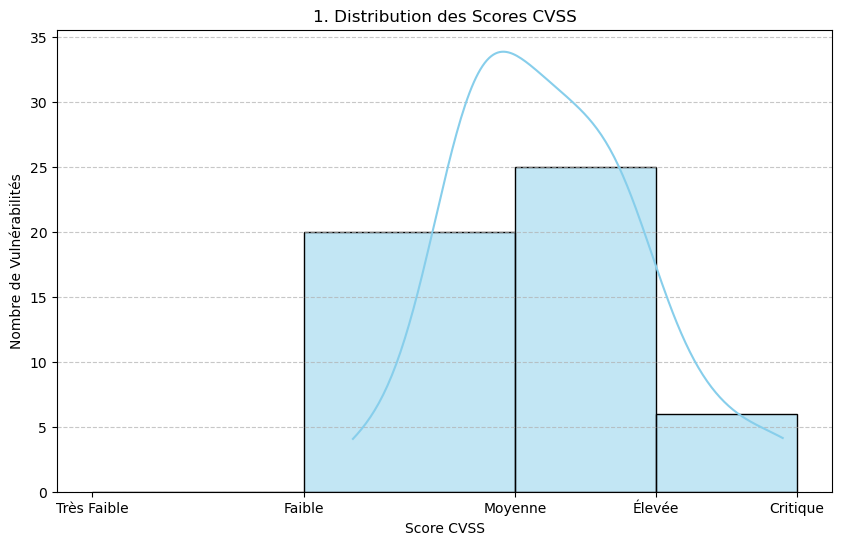

In [ ]:
if "CVSS" in df.columns and df["CVSS"].notna().any() and df["CVSS"].nunique() > 1:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="CVSS", bins=[0, 3, 6, 8, 10], kde=True, color="skyblue")
    plt.title("1. Distribution des Scores CVSS")
    plt.xlabel("Score CVSS")
    plt.ylabel("Nombre de Vulnérabilités")
    plt.xticks([0, 3, 6, 8, 10], labels=["Très Faible", "Faible", "Moyenne", "Élevée", "Critique"])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

 # 2. Courbe cumulative des vulnérabilités dans le temps

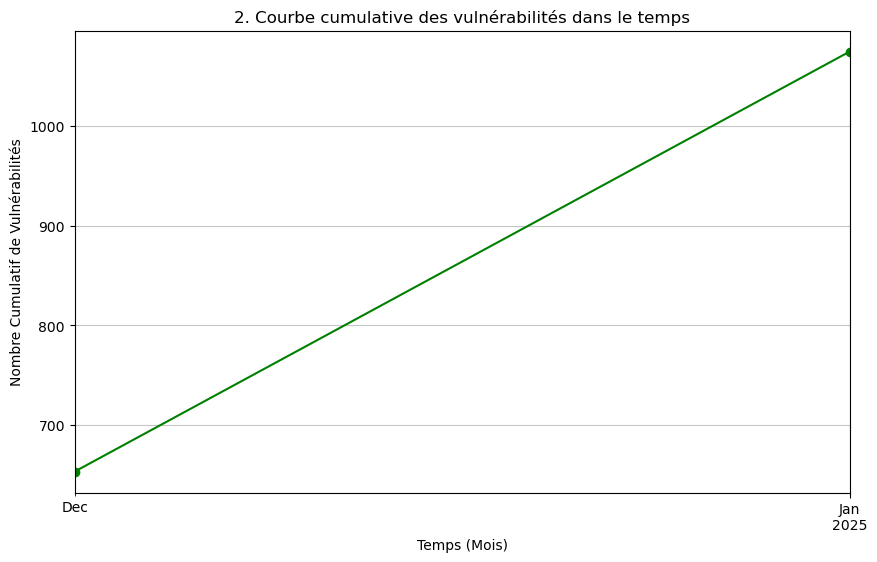

In [ ]:
# Conversion des dates
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

if "Date" in df.columns and df["Date"].notna().any():
    df["Date"] = df["Date"].dt.tz_localize(None)
    cumulative_count = df.groupby(df["Date"].dt.to_period("M")).size().cumsum()
    plt.figure(figsize=(10, 6))
    cumulative_count.plot(kind="line", marker="o", color="green")
    plt.title("2. Courbe cumulative des vulnérabilités dans le temps")
    plt.xlabel("Temps (Mois)")
    plt.ylabel("Nombre Cumulatif de Vulnérabilités")
    plt.grid(alpha=0.7)
    plt.show()


# 3. Diagramme circulaire des CWE

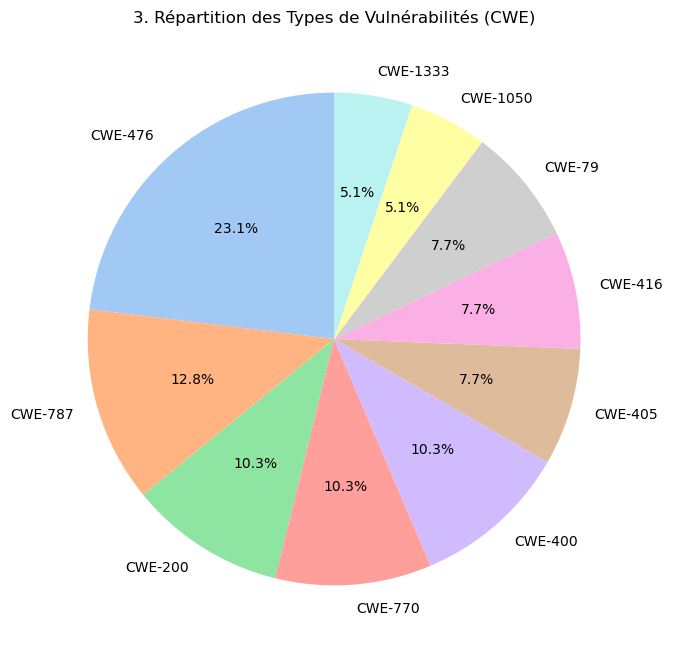

In [ ]:
if "CWE" in df.columns and df["CWE"].notna().any():
    # Filtrer les CWE valides
    filtered_cwe = df[df["CWE"].notna() & (df["CWE"] != "Non disponible")]

    if not filtered_cwe.empty:
        # Compter les CWE les plus fréquents
        cwe_counts = filtered_cwe["CWE"].value_counts().head(10)

        # Tracer le diagramme circulaire
        plt.figure(figsize=(8, 8))
        cwe_counts.plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette("pastel")
        )
        plt.title("3. Répartition des Types de Vulnérabilités (CWE)")
        plt.ylabel("")  # Supprimer le label par défaut
        plt.show()
    else:
        print("Aucune donnée CWE valide pour le graphique.")
else:
    print("La colonne CWE n'existe pas ou est vide.")


# 4. Courbe des scores EPSS

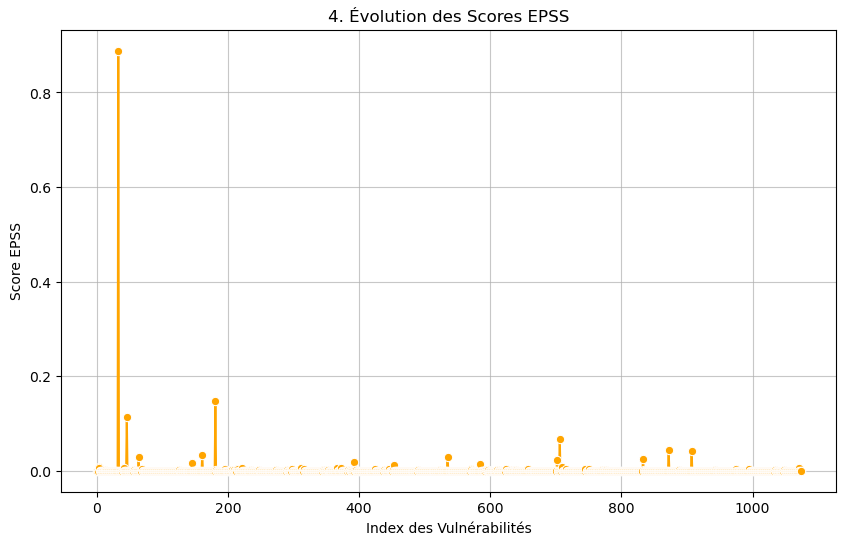

In [ ]:
if "EPSS" in df.columns and df["EPSS"].notna().any():
    if df["EPSS"].nunique() > 1:  # Vérifie qu'il y a plus d'une valeur unique
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df.reset_index(), x=df.index, y="EPSS", marker="o", color="orange")
        plt.title("4. Évolution des Scores EPSS")
        plt.xlabel("Index des Vulnérabilités")
        plt.ylabel("Score EPSS")
        plt.grid(alpha=0.7)
        plt.show()
    else:
        print("Pas assez de valeurs uniques pour tracer la courbe des scores EPSS.")

# 5. Classement des produits ou éditeurs les plus affectés

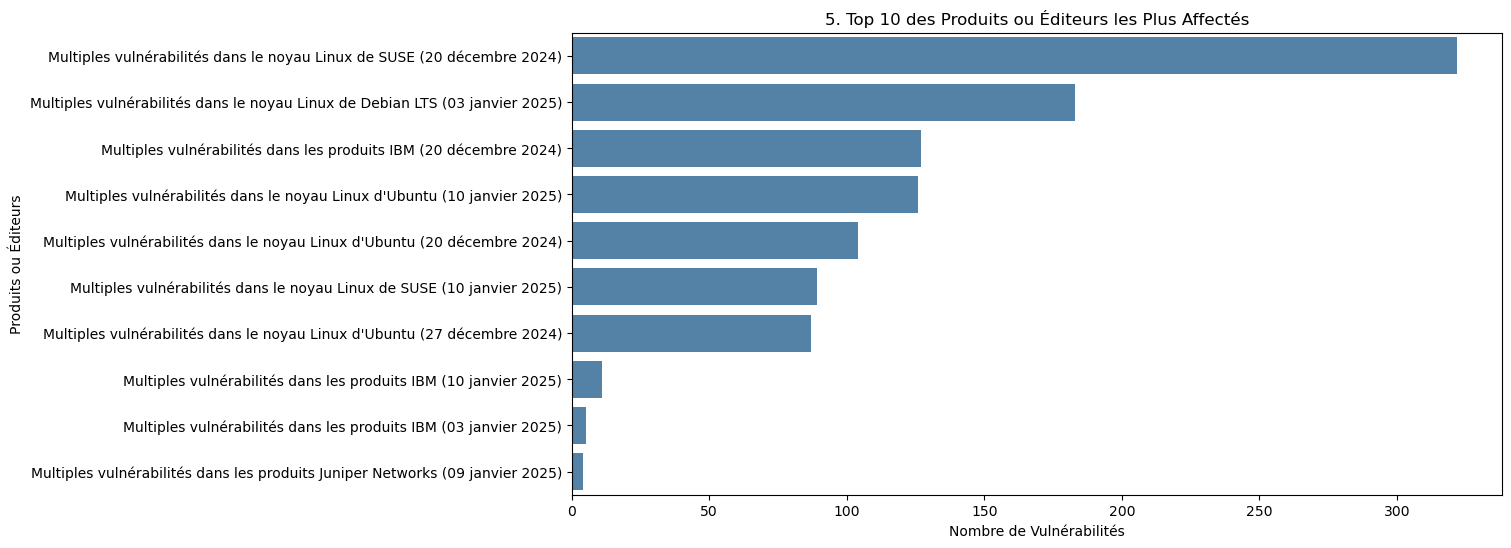

In [ ]:

if "Titre" in df.columns and df["Titre"].notna().any():
    top_products = df["Titre"].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(y=top_products.index, x=top_products.values, color="steelblue")
    plt.title("5. Top 10 des Produits ou Éditeurs les Plus Affectés")
    plt.xlabel("Nombre de Vulnérabilités")
    plt.ylabel("Produits ou Éditeurs")
    plt.show()


# 6. Analyse spécifique des CWE les plus fréquentes

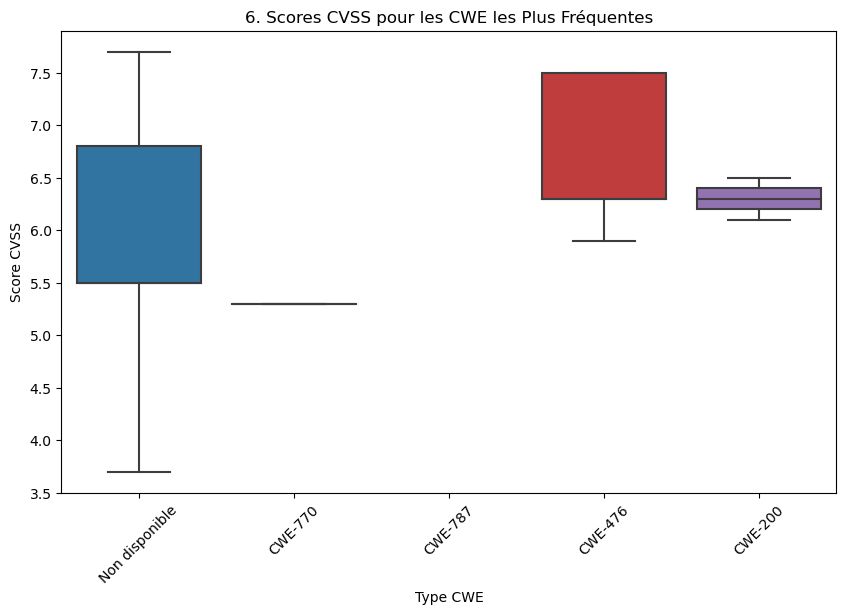

In [ ]:
if "CWE" in df.columns and "CVSS" in df.columns and df["CWE"].notna().any():
    # Filtrer les données pour les 5 CWE les plus fréquents
    top_cwe_df = df[df["CWE"].isin(df["CWE"].value_counts().head(5).index)]

    # Création du boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=top_cwe_df, x="CWE", y="CVSS", hue=None)
    plt.title("6. Scores CVSS pour les CWE les Plus Fréquentes")
    plt.xlabel("Type CWE")
    plt.ylabel("Score CVSS")
    plt.xticks(rotation=45)

    # Affichage du graphique
    plt.show()


# 7. Heatmap des corrélations entre CVSS et EPSS

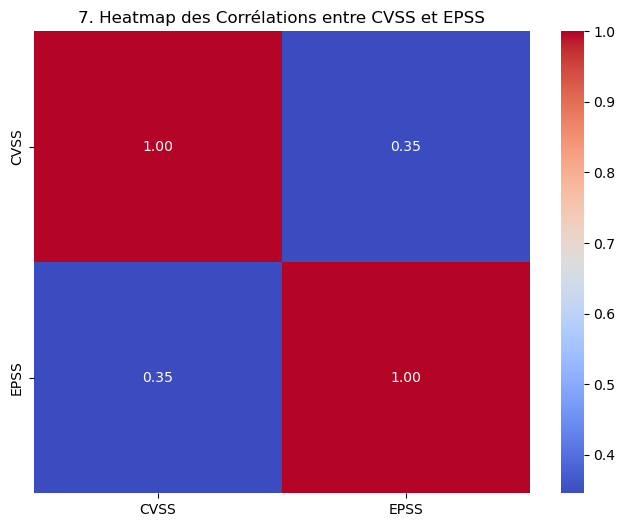

In [ ]:
if "CVSS" in df.columns and "EPSS" in df.columns:
    plt.figure(figsize=(8, 6))
    corr_matrix = df[["CVSS", "EPSS"]].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("7. Heatmap des Corrélations entre CVSS et EPSS")
    plt.show()


# 8. Nuage de points entre Score CVSS et Score EPSS

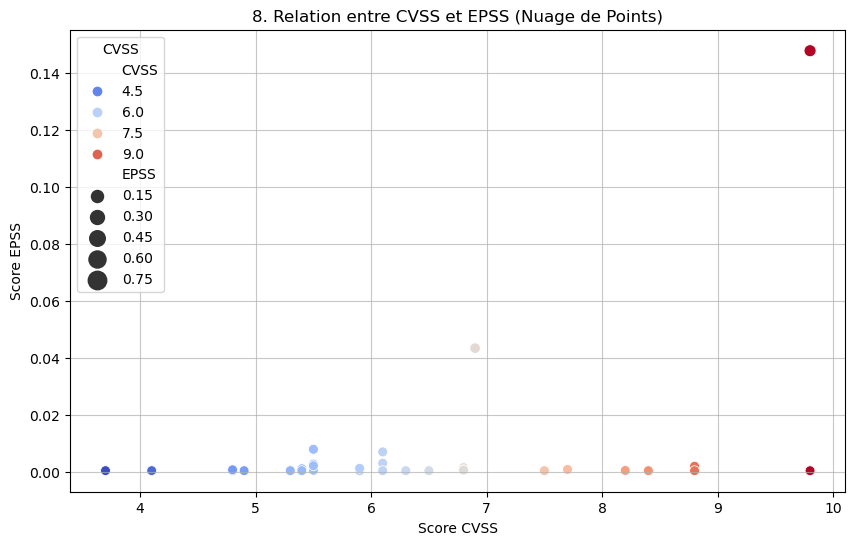

In [ ]:
if "CVSS" in df.columns and "EPSS" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df["CVSS"], y=df["EPSS"], hue=df["CVSS"], palette="coolwarm", size=df["EPSS"], sizes=(50, 200))
    plt.title("8. Relation entre CVSS et EPSS (Nuage de Points)")
    plt.xlabel("Score CVSS")
    plt.ylabel("Score EPSS")
    plt.legend(title="CVSS")
    plt.grid(alpha=0.7)
    plt.show()

# 9. Barplot des scores CVSS moyens par CWE

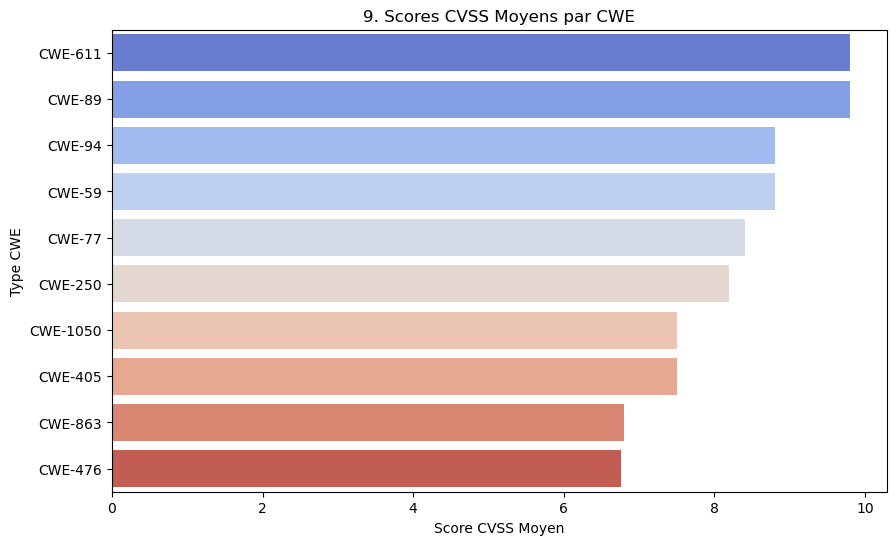

In [ ]:
if "CWE" in df.columns and "CVSS" in df.columns and df["CWE"].notna().any():
    cwe_cvss_avg = df.groupby("CWE")["CVSS"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cwe_cvss_avg.values, y=cwe_cvss_avg.index, palette="coolwarm")
    plt.title("9. Scores CVSS Moyens par CWE")
    plt.xlabel("Score CVSS Moyen")
    plt.ylabel("Type CWE")
    plt.show()



# 10. Barres empilées : CWE par gravité CVSS

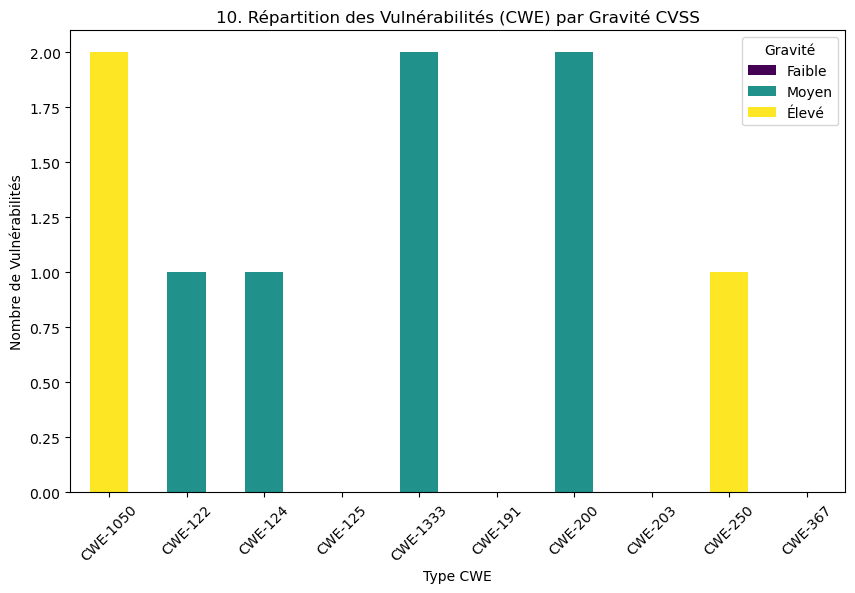

In [ ]:

if "CWE" in df.columns and "CVSS" in df.columns and df["CWE"].notna().any():
    df["Gravité"] = pd.cut(df["CVSS"], bins=[0, 4, 7, 10], labels=["Faible", "Moyen", "Élevé"])
    cwe_gravity = df.groupby(["CWE", "Gravité"]).size().unstack(fill_value=0).head(10)
    cwe_gravity.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
    plt.title("10. Répartition des Vulnérabilités (CWE) par Gravité CVSS")
    plt.xlabel("Type CWE")
    plt.ylabel("Nombre de Vulnérabilités")
    plt.xticks(rotation=45)
    plt.legend(title="Gravité")
    plt.show()
